In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import re
import sys
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

# os.chdir("..") #DIrectory in the main folder

sys.path.insert(1, os.path.join("..")) # Include the modifications_cristopher folder
sys.path.insert(1, os.path.join("..", "..")) # Include the PyRaws main folder
sys.path.insert(1, '/home/cristopher/Documents/PyRawS/') # Include the PyRaws main folder


# !pip install patchify
import pickle
from patchify import patchify

from pyraws.raw.raw_event import Raw_event

from scripts_and_studies.hta_detection_algorithms.s2pix_detector import s2pix_detector

from coregistration_superglue_multiband import SuperGlue_registration



/home/cristopher/miniconda3/envs/pyraws/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def normalize(band):
    # Function that converts 16bits images into 8bits images
    band_max, band_min = band.max(), band.min()
    return (((band - band_min) / ((band_max - band_min))) * 255).astype(np.uint8)

def normalize_0_1_float(band):
    # Function that converts 16bits images into 8bits images
    band_max, band_min = band.max(), band.min()
    return (((band - band_min) / ((band_max - band_min))) ).astype(np.float32)

def normalizeStd(image):
    """Normalize the input around the mean value and twice the standard deviation

    Attributes
    ----------
    image : array
        Image to be normalized with its mean and standard deviation.

    Output :
    ------
    Float32 image.

    Notes
    -----
    Applied normally in visualization purposes. The normalization is better than the normal min and max.
    """
    return (
        (image - (np.nanmean(image) - np.nanstd(image) * 2))
        / (
            (np.nanmean(image) + np.nanstd(image) * 2)
            - (np.nanmean(image) - np.nanstd(image) * 2)
        )
    ).astype(np.float32)


def _normalize_to_0_to_1(img):
    """Normalizes the passed image to 0 to 1

    Args:
        img (np.array): image to normalize

    Returns:
        np.array: normalized image
    """
    # img = img + np.minimum(0, np.min(img))  # move min to 0
    # img = img / np.max(img)  # scale to 0 to 1
    img = img / 4095  # scale to 0 to 1
    return img


def check_potential_new_events(image_name,source_folder):
    # image_name = os.path.basename(image_path)

    # source_folder = '/home/cristopher/Documents/END2END/MSMatch/data'

    potential_event_condition = False
    confirmed_fire_condition = False
    
    for _, _, files in os.walk(source_folder):
        
        for file in files:

            file_name_MSMatch = re.match(r'(.+)_\(', file).group(1)
            # print(file_name_MSMatch)
            # print(file_name_old)
            if re.match(r'(.+)_\(', image_name).group(1) == file_name_MSMatch:
                confirmed_fire_condition = True
                # print(file_name_MSMatch)
            
    if not confirmed_fire_condition:

        # potential_fires_list.append(re.match(r'(.+)_\(', image_name).group(1))
        
        potential_event_condition = True

    return potential_event_condition

In [3]:
# def castro_contextual_conditions(input_image,neighborhood_size = 30):

#     ### Transpose because OPenCV works with BGR images. 2 band is B12, 1 is B11 and 0 is B8A
    
#     # final_image = np.transpose(new_image),(1,2,0)
    
#     input_image = input_image[:,:,::-1]

#     neighborhood_size = 30


#     mask0 = ~np.any(input_image == 0)
#     new_image = input_image*mask0
#     # print(new_image.shape)

#     #Murphy conditions (Massimetti uses mask2 >= 1.2)
#     mask1 =  new_image[:,:,2]/new_image[:,:,1] >= 1.4
#     mask2 =  new_image[:,:,2]/new_image[:,:,0] >= 1.4
#     mask3 =  new_image[:,:,2] >= 0.15#*255



#     # mask4 =  new_image[:,:,1]/new_image[:,:,0] >=2
#     mask4 =  np.logical_and(new_image[:,:,2] >100/255,new_image[:,:,0] < 15/255)

#     # Condition for surrounding clouds with high values of SWIR bands
#     mask5 = np.logical_and(np.logical_or(new_image[:,:,2]>=150/255,new_image[:,:,1]>=150/255),new_image[:,:,0]<60/255)
#     # mask5 = np.logical_or(new_image[:,:,2]>=150,new_image[:,:,1]>=150)

#     ## Hottest pixel conditions (almost white)
#     # mask6 = np.logical_and(np.logical_and(new_image[:,:,2]>=180,new_image[:,:,1]>=180),new_image[:,:,0]>125)
#     mask6 = np.logical_and(new_image[:,:,2]>=180/255,new_image[:,:,1]>=180/255)
    
#     #These 3 conditions can be in 1 line
#     mask_combined = np.logical_and(mask1,np.logical_and(mask2,np.logical_and(mask3,mask4)))
    
#     mask_combined = np.logical_or(mask_combined,mask5)

#     mask_combined = np.logical_or(mask_combined,mask6)

#     mask_combined_temp = mask_combined.copy()


#     for i in range(mask_combined.shape[0]):
#             for j in range(mask_combined.shape[1]):
#                 if mask_combined[i, j]:

#                     neighbor_window = mask_combined[
#                         max(0, i - neighborhood_size // 2) : i
#                         + neighborhood_size // 2
#                         + 1,
#                         max(0, j - neighborhood_size // 2) : j
#                         + neighborhood_size // 2
#                         + 1,
#                     ]

#                     condition_1 = (
#                         new_image[
#                             max(0, i - neighborhood_size // 2) : i
#                             + neighborhood_size // 2
#                             + 1,
#                             max(0, j - neighborhood_size // 2) : j
#                             + neighborhood_size // 2
#                             + 1,
#                             2
#                         ]
#                         / new_image[
#                             max(0, i - neighborhood_size // 2) : i
#                             + neighborhood_size // 2
#                             + 1,
#                             max(0, j - neighborhood_size // 2) : j
#                             + neighborhood_size // 2
#                             + 1,
#                             1
#                         ]
#                         >= 4
#                     )

#                     condition_2 = (
#                         new_image[
#                             max(0, i - neighborhood_size // 2) : i
#                             + neighborhood_size // 2
#                             + 1,
#                             max(0, j - neighborhood_size // 2) : j
#                             + neighborhood_size // 2
#                             + 1,
#                             0
#                         ]
#                         < 0.1
#                     )
                    
#                     mask_combined_temp[
#                         max(0, i - neighborhood_size // 2) : i
#                         + neighborhood_size // 2
#                         + 1,
#                         max(0, j - neighborhood_size // 2) : j
#                         + neighborhood_size // 2
#                         + 1,
#                     ] = np.logical_or(
#                         neighbor_window,  np.logical_and(condition_1, condition_2)
#                         # neighbor_window,  condition_1
#                     )

#     mask_combined = mask_combined_temp

#     # Condition for the inner pixels that were not detected before
#     for i in range(mask_combined.shape[0]):
#         for j in range(mask_combined.shape[1]):
#             if np.sum(mask_combined[
#                 max(0, i - 1) : i + 2,
#                 max(0, j - 1) : j + 2,
#             ]) >= 7:
#                 mask_combined[i,j]=True

#     mask_broadcasted = np.stack([mask_combined] * 3, axis=-1).astype(np.uint8)*255

#     return mask_broadcasted

# def Murphy_conditions(input_image,neighborhood_size = 8):
    
#     input_image = input_image[:,:,::-1]

#     mask0 = ~np.any(input_image == 0)
#     new_image = input_image*mask0
#     ### Murphy conditions initial fire pixels

#     mask1 = new_image[:, :, 2] / new_image[:, :, 1] >= 1.4
#     mask2 = new_image[:, :, 2] / new_image[:, :, 0] >= 1.4
#     mask3 = new_image[:, :, 2] >= 0.15 

#     mask_combined = np.logical_and(mask1, np.logical_and(mask2, mask3))


#     ### Murphy conditions potential fire pixels

#     mask_combined_temp = mask_combined.copy()

#     for i in range(mask_combined.shape[0]):
#         for j in range(mask_combined.shape[1]):
#             if mask_combined[i, j]:


#                 neighbor_window = mask_combined[
#                     max(0, i - neighborhood_size // 2) : i
#                     + neighborhood_size // 2
#                     + 1,
#                     max(0, j - neighborhood_size // 2) : j
#                     + neighborhood_size // 2
#                     + 1,
#                 ]

#                 condition_1 = (
#                     new_image[
#                         max(0, i - neighborhood_size // 2) : i
#                         + neighborhood_size // 2
#                         + 1,
#                         max(0, j - neighborhood_size // 2) : j
#                         + neighborhood_size // 2
#                         + 1,
#                         1
#                     ]
#                     / new_image[
#                         max(0, i - neighborhood_size // 2) : i
#                         + neighborhood_size // 2
#                         + 1,
#                         max(0, j - neighborhood_size // 2) : j
#                         + neighborhood_size // 2
#                         + 1,
#                         0
#                     ]
#                     >= 2
#                 )

#                 condition_2 = (
#                     new_image[
#                         max(0, i - neighborhood_size // 2) : i
#                         + neighborhood_size // 2
#                         + 1,
#                         max(0, j - neighborhood_size // 2) : j
#                         + neighborhood_size // 2
#                         + 1,
#                         1
#                     ]
#                     > 0.5
#                 )
                
#                 mask_combined_temp[
#                     max(0, i - neighborhood_size // 2) : i
#                     + neighborhood_size // 2
#                     + 1,
#                     max(0, j - neighborhood_size // 2) : j
#                     + neighborhood_size // 2
#                     + 1,
#                 ] = np.logical_or(
#                     neighbor_window,  np.logical_and(condition_1, condition_2)
#                 )

#     mask_combined = mask_combined_temp

#     mask_broadcasted = np.stack([mask_combined] * 3, axis=-1).astype(np.uint8)*255

#     return mask_broadcasted

# def Massimetti_conditions(input_image):

#     _, raw_filtered_alert_matrix, _ = s2pix_detector(torch.Tensor(input_image))

#     mask_broadcasted = np.stack([raw_filtered_alert_matrix.bool()] * 3, axis=-1).astype(np.uint8)*255

#     return mask_broadcasted

Etna_00


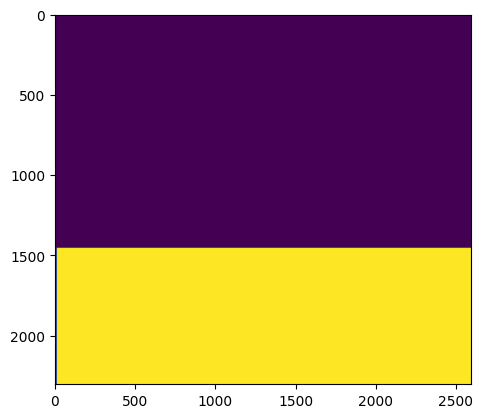

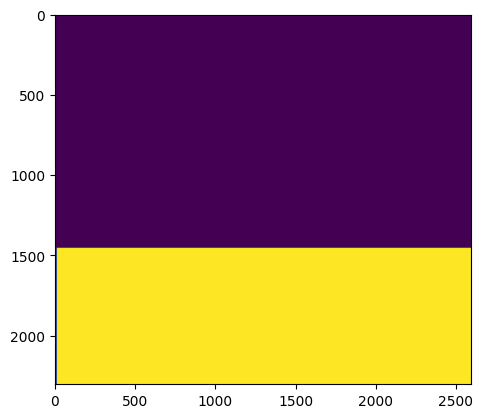

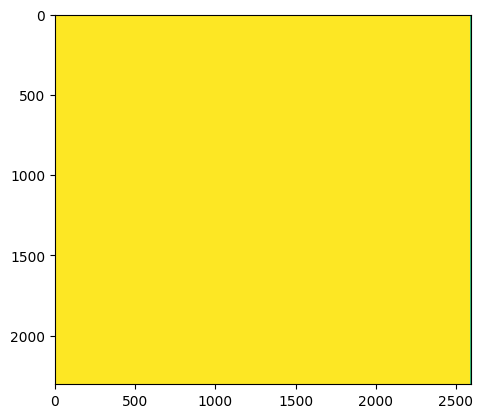

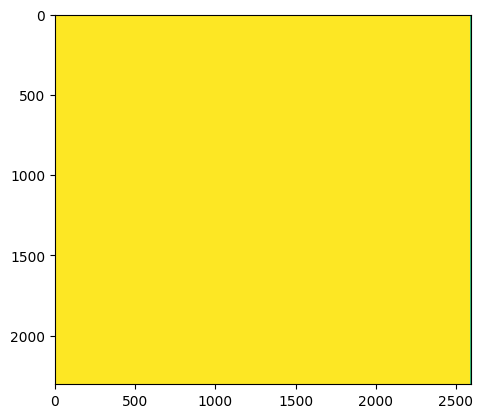

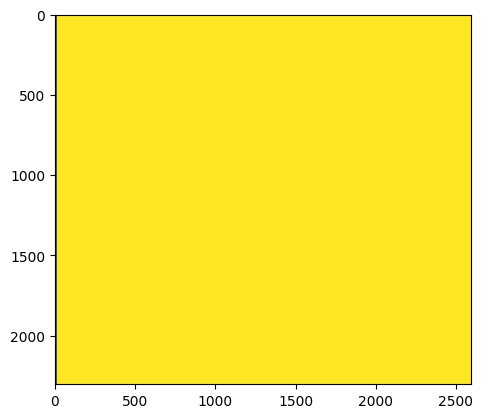

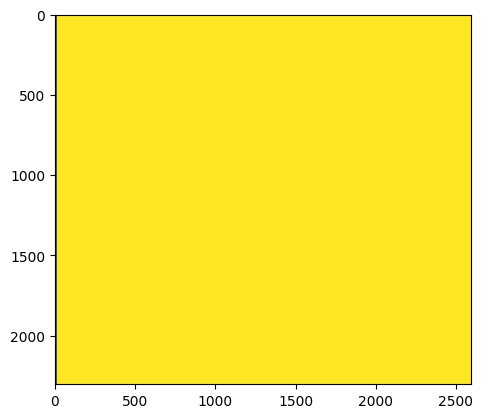

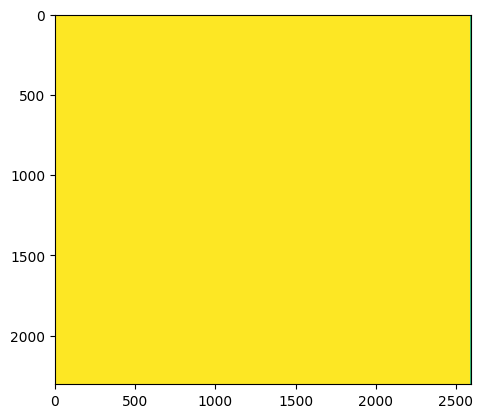

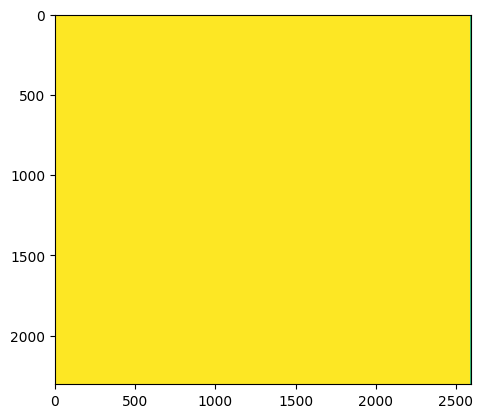

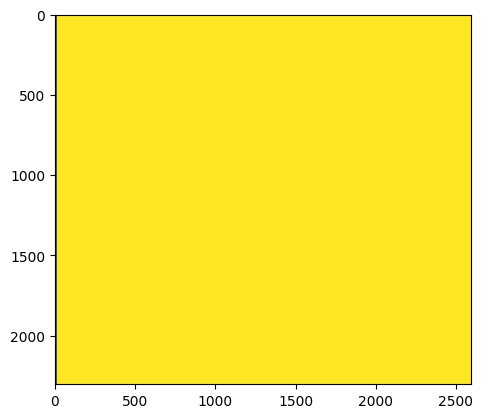

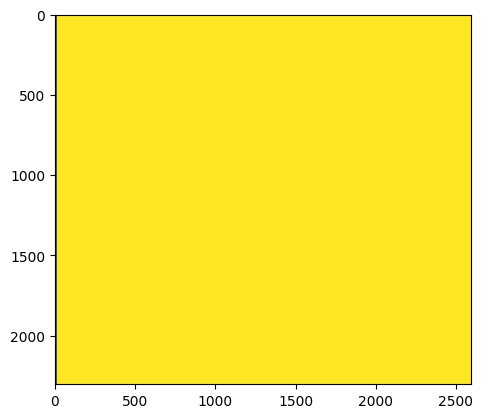

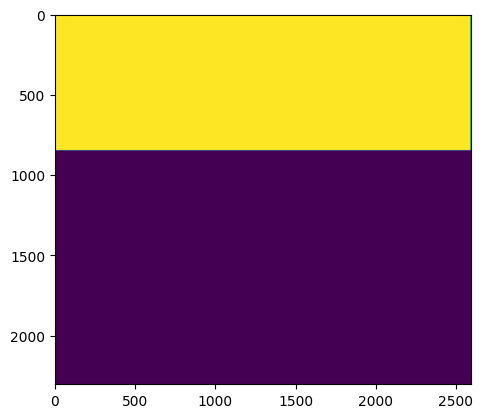

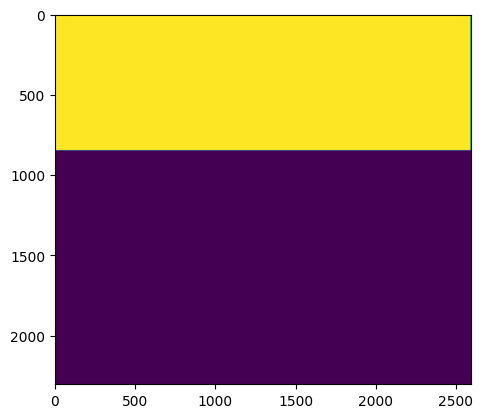

In [5]:
%matplotlib inline

from threshold_conditions import Castro_Traba_conditions,Murphy_conditions,Massimetti_conditions,Schroeder_conditions, Kumar_Roy_conditions

# pyraws_path = os.path.dirname(os.path.dirname(os.getcwd()))

# data_path = os.path.join(pyraws_path, "data", "raw")
data_path = '/home/cristopher/Documents/PyRawS/data/raw/'
break_condition = False

bands_list = ["B12", "B11", "B8A", "B02", "B03", "B04"]
# bands_list = ["B12", "B11", "B8A"]

# bands_list = [ "B8A", "B11", "B12","B04", "B03", "B02","B08", "B07", "B06","B05","B01"]
bands_list = [ "B02", "B08", "B03", "B10","B04", "B05","B11", "B06", "B07","B8A","B12","B01"]

def testing(event_path,bands_list):

    raw_event = Raw_event()

    # Read event from data
    raw_event.from_path(  # Path to the event
        raw_dir_path=event_path,
        # Bands to open. Leave to None to use all the bands.
        bands_list=bands_list,
        # If True, verbose mode is on.
        verbose=False,
    )

    raw_granule = raw_event.get_granule(granule_idx).as_tensor()




    raw_coreg_granule = raw_event.coarse_coregistration(  # granule index to coarse coregister.
        granules_idx=[granule_idx],
        # Search for filling elements
        # among adjacent Raw granules
        downsampling=False,
        use_complementary_granules=True,
        crop_empty_pixels=False,                            ############################# Crop empty disabled to get always the entire image
    )
    raw_coreg_granule = raw_coreg_granule.as_tensor(downsampling=False).numpy()
    return raw_coreg_granule




source_folder = os.path.join(os.path.dirname(os.getcwd()),'THRAWS_END2END')

events_images_NIR_SWIR_path = os.path.join(os.getcwd(),'dataset','images','event','NIR_SWIR')

break_condition  = False
cont = 0
coarse_granules = []
scene_groups_paths = [
            os.path.join(data_path,d) for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))
        ]
for scene_group_path in scene_groups_paths:

    scenes_paths = [
            os.path.join(scene_group_path,scene_name) for scene_name in os.listdir(scene_group_path) if os.path.isdir(os.path.join(scene_group_path, scene_name))
        ]
    for scene_path in scenes_paths:
        granules_paths = [
            os.path.join(scene_path,granule_name) for granule_name in os.listdir(scene_path) if os.path.isdir(os.path.join(scene_path, granule_name))
        ]
        # print(granules_paths)
        scene_group = os.path.basename(scene_group_path)
        scene_name = os.path.basename(scene_path)
        print(scene_name)

        for granule_idx,granule_path in enumerate(granules_paths):
            
            # if scene_name=='Etna_00' and granule_idx == 2:

            # raw_coreg_granule,coarse_status = SuperGlue_registration(bands_list=bands_list,event_path=scene_path,granule_idx=granule_idx)

            raw_coreg_granule = testing(event_path=scene_path,bands_list=bands_list)
            # print(raw_coreg_granule.shape)
            # raw_coreg_granule = raw_coreg_granule.as_tensor().numpy()
            # if coarse_status:
            #     coarse_granules.append(f'{scene_name}_G_{granule_idx}')
            #     coarse_status=False
                

            # i = 0;j=0
            # NIR_SWIR_name = f'{scene_name}_G{granule_idx}_({j*192}, {i*192}, {256+j*192}, {256+i*192})_NIR_SWIR'
            
            NIR_SWIR_image = _normalize_to_0_to_1(np.dstack((raw_coreg_granule[:,:,-2],raw_coreg_granule[:,:,6],raw_coreg_granule[:,:,-3])))
            # NIR_SWIR_image = (np.dstack((raw_coreg_granule[:,:,9],raw_coreg_granule[:,:,0],raw_coreg_granule[:,:,0])))


            mask0 = np.all(raw_coreg_granule != 0,axis=2)
            new_image = (raw_coreg_granule*mask0[:,:,np.newaxis])
            empty_image_pattern = new_image[:,:,0]
            plt.figure()
            plt.imshow(mask0)
            mask1 = ~np.any(raw_coreg_granule == 0,axis=2)
            # new_image = (raw_coreg_granule*mask0[:,:,np.newaxis])
            # empty_image_pattern = new_image[:,:,0]
            plt.figure()
            plt.imshow(mask1)



            # NIR_SWIR_patch = _normalize_to_0_to_1(np.dstack((raw_coreg_granule[:,:,bands_list.index('B12')],
            #                                 raw_coreg_granule[:,:,bands_list.index('B11')],
            #                                 raw_coreg_granule[:,:,bands_list.index('B8A')])))

            # RGB_patch = _normalize_to_0_to_1(np.dstack((raw_coreg_granule[:,:,bands_list.index('B04')],
            #                             raw_coreg_granule[:,:,bands_list.index('B03')],
            #                             raw_coreg_granule[:,:,bands_list.index('B02')])))

            # VNIR_patch = _normalize_to_0_to_1(np.dstack((raw_coreg_granule[:,:,bands_list.index('B07')],
            #                             raw_coreg_granule[:,:,bands_list.index('B06')],
            #                             raw_coreg_granule[:,:,bands_list.index('B05')])))

            # B01_patch = _normalize_to_0_to_1(raw_coreg_granule[:,:,bands_list.index('B01')])

                            
            # image_multiband = np.dstack((NIR_SWIR_patch,RGB_patch,B01_patch))


            # castro_traba_mask = Castro_Traba_conditions(input_image=NIR_SWIR_image,
            #                         empty_pixels_pattern=mask0)

            # murphy_mask = Murphy_conditions(input_image=NIR_SWIR_image,
            #             empty_pixels_pattern=mask0)
            
            # massimetti_mask = Massimetti_conditions(input_image=NIR_SWIR_image,
            #                         empty_pixels_pattern=mask0)
            
            # schroeder_mask = Schroeder_conditions(input_image=image_multiband,
            #                         empty_pixels_pattern=mask0)
            
            # kumar_roy_mask = Kumar_Roy_conditions(input_image=image_multiband,
            #                         empty_pixels_pattern=mask0)
            
            # # mask1 =  np.divide(new_image[:,:,-2],new_image[:,:,6],out=np.zeros_like(new_image[:,:,0]),where=(mask0==True)) >= 1.4
            # # mask2 =  new_image[:,:,-2]/new_image[:,:,-3] >= 1.4
            # # mask3 =  new_image[:,:,-2] >= 0.15#*255

            # # plt.figure()
            # # plt.imshow(mask1)
            # # common_area = (raw_coreg_granule[:,:,-1]*raw_coreg_granule[:,:,0])>0
            # # print(common_area.shape)
            # # NIR_SWIR_image = raw_coreg_granule[:,:,10]*common_area

            # # new_image = 
            # # print(NIR_SWIR_image[common_area])

            # # NIR_SWIR_image = _normalize_to_0_to_1(raw_coreg_granule[:,:,5])

            # # NIR_SWIR_image = _normalize_to_0_to_1(raw_coreg_granule[:, :, :3])
            # # NIR_SWIR_patches = patchify(NIR_SWIR_image, (256,256,3), step=192)
            # # NIR_SWIR_patch = NIR_SWIR_patches[i,j,:,:,:].reshape(256,256,3)
            
            # fig, ax = plt.subplots(2,3,figsize = (20,10))
            # ax = ax.flatten()
            # title_list = ['NIR_SWIR',
            #               'castro_traba',
            #               'murphy',
            #               'massimetti',
            #               'schroeder',
            #               'kumar_roy']
            # for i,element in enumerate([NIR_SWIR_image,castro_traba_mask,murphy_mask,massimetti_mask,schroeder_mask,kumar_roy_mask]):
            #     ax[i].imshow(element)
            #     ax[i].set_title(title_list[i])


            plt.show()
    #         break_condition = True
    #         break

    #     if break_condition:
    #         break
    # if break_condition:
    #         break
                # with open(os.path.join(events_images_NIR_SWIR_path,NIR_SWIR_name+'.pkl'),'wb') as f:
                #                         pickle.dump(NIR_SWIR_patch, f)
                
                # print('Image saved')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


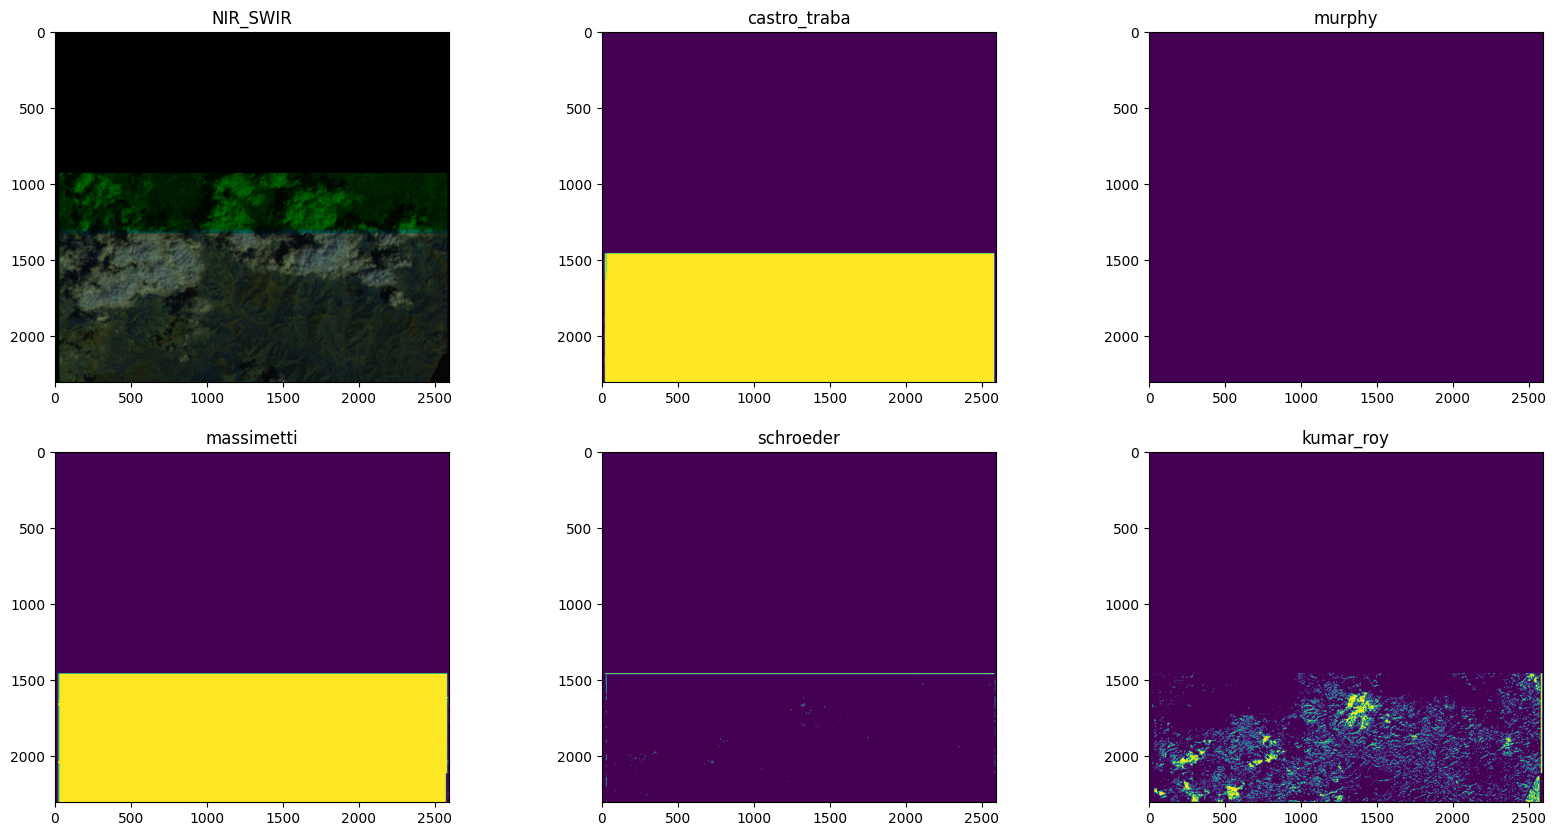

In [41]:
fig, ax = plt.subplots(2,3,figsize = (20,10))
ax = ax.flatten()
title_list = ['NIR_SWIR',
                'castro_traba',
                'murphy',
                'massimetti',
                'schroeder',
                'kumar_roy']
for i,element in enumerate([NIR_SWIR_image,castro_traba_mask,murphy_mask,massimetti_mask,schroeder_mask,kumar_roy_mask]):
    ax[i].imshow(element)
    ax[i].set_title(title_list[i])


plt.show()

In [35]:
print(np.unique(kumar_roy_mask))

[0. 1.]


0.7960928 0.01929182


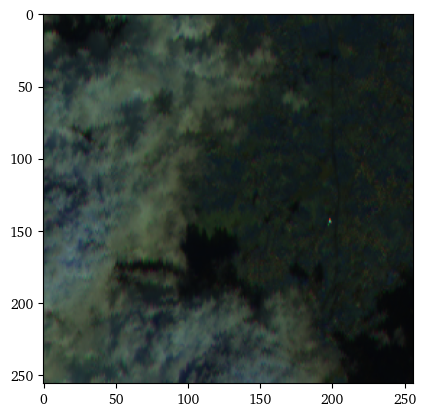

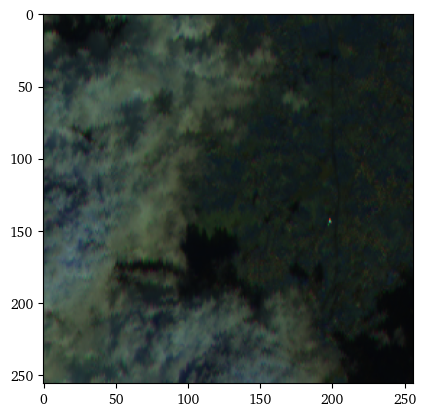

In [77]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import cv2
import numpy as np

with open('/home/cristopher/Desktop/testing_docker/dataset/images/event/NIR_SWIR/Etna_00_G2_(768, 384, 1024, 640)_NIR_SWIR.pkl','rb') as image_file:
    original_image = pickle.load(image_file)

plt.figure()
plt.imshow((original_image))

with open('/home/cristopher/Desktop/testing_docker/train_dataset/train/images/Etna_00_G2_(768, 384, 1024, 640)_NIR_SWIR.bin','rb') as new_file:
    image_bin = new_file.read()
    image = np.frombuffer(image_bin,dtype=np.float32).reshape(256,256,3)



# cv2.imwrite('mask.jpg',original_image)

# new = cv2.imread('mask.jpg')

plt.figure()
plt.imshow((image))

print(original_image.max(),original_image.min())


In [ ]:
##### Testing classify new events

pyraws_path = os.path.dirname(os.path.dirname(os.getcwd()))



data_path = os.path.join(pyraws_path, "data", "raw")

break_condition = False

bands_list = ["B12", "B11", "B8A", "B02", "B03", "B04"]
# bands_list = ["B12", "B11", "B8A"]

source_folder = os.path.join(os.path.dirname(os.getcwd()),'THRAWS_END2END')




events_images_NIR_SWIR_path = os.path.join(os.getcwd(),'dataset','images','event','NIR_SWIR')
notevents_images_NIR_SWIR_path = os.path.join(os.getcwd(),'dataset','images','notevent','NIR_SWIR')
potential_events_images_NIR_SWIR_path = os.path.join(os.getcwd(),'dataset','images','potential_event','NIR_SWIR')

events_images_RGB_path = os.path.join(os.getcwd(),'dataset','images','event','RGB')
notevents_images_RGB_path = os.path.join(os.getcwd(),'dataset','images','notevent','RGB')
potential_events_images_RGB_path = os.path.join(os.getcwd(),'dataset','images','potential_event','RGB')

Castro_Traba_masks_path = os.path.join(os.getcwd(),'dataset','masks','Castro-Traba','event')
Castro_Traba_potential_masks_path = os.path.join(os.getcwd(),'dataset','masks','Castro-Traba','potential_event')

Massimetti_masks_path = os.path.join(os.getcwd(),'dataset','masks','Massimetti','event')
Massimetti_potential_masks_path = os.path.join(os.getcwd(),'dataset','masks','Massimetti','potential_event')

Murphy_masks_path = os.path.join(os.getcwd(),'dataset','masks','Murphy','event')
Murphy_potential_masks_path = os.path.join(os.getcwd(),'dataset','masks','Murphy','potential_event')

os.makedirs(events_images_NIR_SWIR_path,exist_ok=True)
os.makedirs(notevents_images_NIR_SWIR_path,exist_ok=True)
os.makedirs(potential_events_images_NIR_SWIR_path,exist_ok=True)
os.makedirs(events_images_RGB_path,exist_ok=True)
os.makedirs(notevents_images_RGB_path,exist_ok=True)
os.makedirs(potential_events_images_RGB_path,exist_ok=True)
os.makedirs(Castro_Traba_masks_path,exist_ok=True)
os.makedirs(Castro_Traba_potential_masks_path,exist_ok=True)
os.makedirs(Massimetti_masks_path,exist_ok=True)
os.makedirs(Massimetti_potential_masks_path,exist_ok=True)
os.makedirs(Murphy_masks_path,exist_ok=True)
os.makedirs(Murphy_potential_masks_path,exist_ok=True)




cont = 0
coarse_granules = []
scene_groups_paths = [
            os.path.join(data_path,d) for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))
        ]
for scene_group_path in scene_groups_paths:

    scenes_paths = [
            os.path.join(scene_group_path,scene_name) for scene_name in os.listdir(scene_group_path) if os.path.isdir(os.path.join(scene_group_path, scene_name))
        ]
    for scene_path in scenes_paths:
        granules_paths = [
            os.path.join(scene_path,granule_name) for granule_name in os.listdir(scene_path) if os.path.isdir(os.path.join(scene_path, granule_name))
        ]
        # print(granules_paths)

        for granule_idx,granule_path in enumerate(granules_paths):
            scene_group = os.path.basename(scene_group_path)
            scene_name = os.path.basename(scene_path)
            
            if scene_name[-3:]!='_NE':

                raw_coreg_granule,coarse_status = SuperGlue_registration(bands_list=bands_list,event_path=scene_path,granule_idx=granule_idx)

                raw_coreg_granule = raw_coreg_granule.as_tensor().numpy()
                if coarse_status:
                    coarse_granules.append(f'{scene_name}_G_{granule_idx}')
                    coarse_status=False
                    

                NIR_SWIR_image = _normalize_to_0_to_1(raw_coreg_granule[:, :, :3])
                NIR_SWIR_patches = patchify(NIR_SWIR_image, (256,256,3), step=192)
        
                RGB_image = _normalize_to_0_to_1(raw_coreg_granule[:, :, 3:])
                RGB_patches = patchify(RGB_image, (256,256,3), step=192)


                for i in range(NIR_SWIR_patches.shape[0]):
                    for j in range(NIR_SWIR_patches.shape[1]):
                        
                        NIR_SWIR_name = f'{scene_name}_G{granule_idx}_({j*192}, {i*192}, {256+j*192}, {256+i*192})_NIR_SWIR'
                        RGB_name = f'{scene_name}_G{granule_idx}_({j*192}, {i*192}, {256+j*192}, {256+i*192})_RGB'

                        NIR_SWIR_patch = NIR_SWIR_patches[i,j,:,:,:].reshape(256,256,3)
                        RGB_patch = RGB_patches[i,j,:,:,:].reshape(256,256,3)
                        
                        
                        image_mask_castro = castro_contextual_conditions(input_image = NIR_SWIR_patch)
                        image_mask_massimetti = Massimetti_conditions(input_image = NIR_SWIR_patch)
                        image_mask_murphy = Murphy_conditions(input_image = NIR_SWIR_patch)

                        if np.any(image_mask_castro) or np.any(image_mask_massimetti) or np.any(image_mask_murphy):
                            
                            additional_event_condition = check_potential_new_events(NIR_SWIR_name,source_folder)

                            if additional_event_condition:
                                #Potential event not included in the END2END database
                                with open(os.path.join(potential_events_images_NIR_SWIR_path,NIR_SWIR_name+'.pkl'),'wb') as f:
                                        pickle.dump(NIR_SWIR_patch, f)
                                    
                                with open(os.path.join(potential_events_images_RGB_path,RGB_name+'.pkl'),'wb') as f:
                                    pickle.dump(RGB_patch, f)

                                if np.any(image_mask_castro):

                                    with open(os.path.join(Castro_Traba_potential_masks_path,NIR_SWIR_name+'_mask.pkl'),'wb') as f:
                                        pickle.dump(image_mask_castro, f)

                                if np.any(image_mask_massimetti):
                                    with open(os.path.join(Massimetti_potential_masks_path,NIR_SWIR_name+'_mask.pkl'),'wb') as f:
                                        pickle.dump(image_mask_massimetti, f)

                                if np.any(image_mask_murphy):
                                    with open(os.path.join(Murphy_potential_masks_path,NIR_SWIR_name+'_mask.pkl'),'wb') as f:
                                        pickle.dump(image_mask_murphy, f)
                            else:
                                #Event already included in the END2END database
                                with open(os.path.join(events_images_NIR_SWIR_path,NIR_SWIR_name+'.pkl'),'wb') as f:
                                        pickle.dump(NIR_SWIR_patch, f)
                                    
                                with open(os.path.join(events_images_RGB_path,RGB_name+'.pkl'),'wb') as f:
                                    pickle.dump(RGB_patch, f)
                                if np.any(image_mask_castro):
                                    with open(os.path.join(Castro_Traba_masks_path,NIR_SWIR_name+'_mask.pkl'),'wb') as f:
                                        pickle.dump(image_mask_castro, f)
                                if np.any(image_mask_massimetti):
                                    with open(os.path.join(Massimetti_masks_path,NIR_SWIR_name+'_mask.pkl'),'wb') as f:
                                        pickle.dump(image_mask_massimetti, f)

                                if np.any(image_mask_murphy):
                                    with open(os.path.join(Murphy_masks_path,NIR_SWIR_name+'_mask.pkl'),'wb') as f:
                                        pickle.dump(image_mask_murphy, f)

                        else:
                            #Not event

                            with open(os.path.join(notevents_images_NIR_SWIR_path,NIR_SWIR_name+'.pkl'),'wb') as f:
                                pickle.dump(NIR_SWIR_patch, f)
                            
                            with open(os.path.join(notevents_images_RGB_path,RGB_name+'.pkl'),'wb') as f:
                                pickle.dump(RGB_patch, f)

                # break
            # break
        # break
with open(os.path.join(os.getcwd(),'dataset','granules_coarse_coregistered.txt'),'w') as file:
    file.write('\n'.join(coarse_granules))
    # break


In [23]:
### Visual check if the potential thermal hotspots are correctly identified 

import random

potential_events_images_path = os.path.join(os.getcwd(),'dataset','images','potential_event','NIR_SWIR')

potential_events_masks_castro_traba = os.path.join(os.getcwd(),'dataset','masks','Castro-Traba','potential_event')
potential_events_masks_massimetti = os.path.join(os.getcwd(),'dataset','masks','Massimetti','potential_event')
potential_events_masks_murphy = os.path.join(os.getcwd(),'dataset','masks','Murphy','potential_event')

images_path = [os.path.join(potential_events_images_path,image_path) for image_path in os.listdir(potential_events_images_path)]

random.shuffle(images_path)

source_folder = '/home/cristopher/Documents/END2END/MSMatch/data'

potential_fires_list = []
confirmed_fire_condition = False
cont = 0

for image_path in images_path:

    with open(image_path,'rb') as f:
        
        image = pickle.load(f)


        image_name = os.path.basename(image_path)[:-4]
        
        try:
            image_mask_castro = pickle.load(open(os.path.join(potential_events_masks_castro_traba,image_name+'_mask.pkl'),'rb'))
        except:
            image_mask_castro = np.zeros_like(image).astype(np.uint8)
        
        try:
            image_mask_massimetti = pickle.load(open(os.path.join(potential_events_masks_massimetti,image_name+'_mask.pkl'),'rb'))
        except:
            image_mask_massimetti = np.zeros_like(image).astype(np.uint8)

        try:
            image_mask_murphy = pickle.load(open(os.path.join(potential_events_masks_murphy,image_name+'_mask.pkl'),'rb'))
        except:
            image_mask_murphy = np.zeros_like(image).astype(np.uint8)



        combined_image = np.hstack((normalize(image),image_mask_castro,image_mask_massimetti,image_mask_murphy))
        combined_image_res = cv2.resize(
            combined_image, (combined_image.shape[1] * 2, combined_image.shape[0] * 2)
        )

        cv2.imshow(f'{image_name}',combined_image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        cont +=1
        if cont>10:
            break
        # break
    



In [ ]:
### Check if the events of the End2End database are included in my database

events_train_images_path = '/home/cristopher/Documents/END2END/MSMatch/data/THRAWS/TrainVal/event'
events_test_images_path = '/home/cristopher/Documents/END2END/MSMatch/data/THRAWS/Test/event'

train_images_path = [os.path.join(events_train_images_path,image_path) for image_path in os.listdir(events_train_images_path)]
test_images_path = [os.path.join(events_test_images_path,image_path) for image_path in os.listdir(events_test_images_path)]

images_paths = train_images_path + test_images_path

source_folder = os.path.join(os.getcwd(),'modifications_cristopher','Castro_contextual_database','NIR_SWIR','event','images')

# source_folder = os.path.join(os.getcwd(),'modifications_cristopher','new_database','NIR_SWIR','potential_event','images')

not_segmented_events = []
confirmed_event = False

cont = 0

for image_path in images_paths:

    
    image_name = re.match(r'(.+)_A',os.path.basename(image_path)).group(1)

    
    for file in os.listdir(source_folder):
        
        file_name_MSMatch = re.match(r'(.+)_NIR_SWIR', file).group(1)
        

        if image_name == file_name_MSMatch:
            confirmed_event = True

    
    if not confirmed_event:
        not_segmented_events.append(image_name)
        confirmed_event = False

        
print(len(not_segmented_events)) # 0 if all the events are included in the new database

In [1]:
import os
import re

#### Post-processing to erase the Massimetti images that were creaed incorrectly

database_path = events_images_NIR_SWIR_path = os.path.join(os.getcwd(),'dataset','images')
events_images_NIR_SWIR_path = os.path.join(os.getcwd(),'dataset','images','event','NIR_SWIR')
# notevents_images_NIR_SWIR_path = os.path.join(os.getcwd(),'dataset','images','notevent','NIR_SWIR')
potential_events_images_NIR_SWIR_path = os.path.join(os.getcwd(),'dataset','images','potential_event','NIR_SWIR')


Castro_Traba_masks_path = os.path.join(os.getcwd(),'dataset','masks','Castro-Traba','event')
Castro_Traba_potential_masks_path = os.path.join(os.getcwd(),'dataset','masks','Castro-Traba','potential_event')

Massimetti_masks_path = os.path.join(os.getcwd(),'dataset','masks','Massimetti','event')
Massimetti_potential_masks_path = os.path.join(os.getcwd(),'dataset','masks','Massimetti','potential_event')

Murphy_masks_path = os.path.join(os.getcwd(),'dataset','masks','Murphy','event')
Murphy_potential_masks_path = os.path.join(os.getcwd(),'dataset','masks','Murphy','potential_event')

testing_dataset = (os.path.join(os.getcwd(),'testing'))

Castro_Traba_masks_names_granules = [re.match(r'(.+)_\(',mask_path).group(1) for mask_path in os.listdir(Castro_Traba_masks_path)+os.listdir(Castro_Traba_potential_masks_path)]
Murphy_masks_names_granules = [re.match(r'(.+)_\(',mask_path).group(1) for mask_path in os.listdir(Murphy_masks_path)+os.listdir(Murphy_potential_masks_path)]

Castro_Traba_masks_names_images = [re.match(r'(.+)\)_',mask_path).group(1) for mask_path in os.listdir(Castro_Traba_masks_path)+os.listdir(Castro_Traba_potential_masks_path)]

Murphy_masks_names_images = [re.match(r'(.+)\)_',mask_path).group(1) for mask_path in os.listdir(Murphy_masks_path)+os.listdir(Murphy_potential_masks_path)]


# # cont = 0
# for image in os.listdir(Massimetti_masks_path)+os.listdir(Massimetti_potential_masks_path):

    ### Eliminate granules

    # image = re.match(r'(.+)_\(',image).group(1)
    
    # condition_castro = image not in Castro_Traba_masks_names_granules
    # condition_murphy = image not in Murphy_masks_names_granules

    # if (condition_castro and condition_murphy):
    #     # print(image)
    #     for root,_,files in os.walk(database_path):
    #         for file in files:
    #             # print(file)
                
    #             file_name = re.match(r'(.+)_\(',file).group(1)
                
    #             if file_name == image:
    #                 os.remove(os.path.join(root,file)) #### Uncomment to delete the files
    #                 print(os.path.join(root,file))


    ### Eliminate particular images

    # image = re.match(r'(.+)\)_',image).group(1)

    
    # condition_castro = image not in Castro_Traba_masks_names_images

    # condition_murphy = image not in Murphy_masks_names_images

    
    # if (condition_castro and condition_murphy):
    #     # print(image)
    #     for root,_,files in os.walk(database_path):
    #         for file in files:
    #             # print(file)
                
    #             file_name = re.match(r'(.+)\)_',file).group(1)
                
    #             if file_name == image:
    #                 # os.remove(os.path.join(root,file)) #### Uncomment to delete the files
    #                 print(os.path.join(root,file))
    
        
            
        # image_name = re.match(r'(.+)_mask',image).group(1)+'.pkl'
        
        # if image_name in os.listdir(events_images_NIR_SWIR_path)+os.listdir(potential_events_images_NIR_SWIR_path):
    #         print(re.match(r'(.+)_mask',image).group(1)+'.pkl')
    

    # # cont +=1
    # # if cont>2000:
    # #     break
# print(cont)


In [ ]:
### Add schroeder, massimetti and Kumar-ROy to the entire database

from threshold_conditions import Massimetti_conditions,Schroeder_conditions,Kumar_Roy_conditions
import os
import re
import pickle
import numpy as np

from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 

database_path = os.path.join(os.getcwd(),'dataset','images')


events_images_NIR_SWIR_path = os.path.join(os.getcwd(),'dataset','images','event','NIR_SWIR')
notevents_images_NIR_SWIR_path = os.path.join(os.getcwd(),'dataset','images','notevent','NIR_SWIR')
potential_events_images_NIR_SWIR_path = os.path.join(os.getcwd(),'dataset','images','potential_event','NIR_SWIR')

events_images_RGB_path = os.path.join(os.getcwd(),'dataset','images','event','RGB')
notevents_images_RGB_path = os.path.join(os.getcwd(),'dataset','images','notevent','RGB')
potential_events_images_RGB_path = os.path.join(os.getcwd(),'dataset','images','potential_event','RGB')

Massimetti_masks_path = os.path.join(os.getcwd(),'dataset','masks','Massimetti','event')
Massimetti_potential_masks_path = os.path.join(os.getcwd(),'dataset','masks','Massimetti','potential_event')

Schroeder_masks_path = os.path.join(os.getcwd(),'dataset','masks','Schroeder','event')
Schroeder_potential_masks_path = os.path.join(os.getcwd(),'dataset','masks','Schroeder','potential_event')

Kumar_Roy_masks_path = os.path.join(os.getcwd(),'dataset','masks','Kumar-Roy','event')
Kumar_Roy_potential_masks_path = os.path.join(os.getcwd(),'dataset','masks','Kumar-Roy','potential_event')


source_folder = os.path.join(os.path.dirname(os.getcwd()),'THRAWS_END2END')

os.makedirs(Massimetti_masks_path,exist_ok=True)
os.makedirs(Massimetti_potential_masks_path,exist_ok=True)
os.makedirs(Schroeder_masks_path,exist_ok=True)
os.makedirs(Schroeder_potential_masks_path,exist_ok=True)
os.makedirs(Kumar_Roy_masks_path,exist_ok=True)
os.makedirs(Kumar_Roy_potential_masks_path,exist_ok=True)

cont = 0
file_name_prev = 'False'

for root,_,files in os.walk(database_path):
    
    for file in tqdm(files):
        # print(file)
        file_name = re.match(r'(.+)_\(',file).group(1)
        if file_name != file_name_prev:
            print(file_name)
            file_name_prev = file_name
        if re.match(r'(.+)_NIR_SWIR',file):
            # print(os.path.join(root,file))
            image_NIR_SWIR = pickle.load(open(os.path.join(root,file),'rb'))
            image_RGB = pickle.load(open(os.path.join(os.path.dirname(root),'RGB',re.match(r'(.+)_NIR_SWIR',file).group(1)+'_RGB.pkl'),'rb'))
            image_multiband = np.dstack((image_NIR_SWIR,image_RGB))

            image_mask_massimetti = Massimetti_conditions(image_NIR_SWIR)
            image_mask_schroeder = Schroeder_conditions(image_multiband)
            image_mask_kumar_roy = Kumar_Roy_conditions(image_multiband)

            NIR_SWIR_name = file[:-4]
            RGB_name = re.match(r'(.+)_NIR_SWIR',file).group(1)+'_RGB'

            additional_event_condition = check_potential_new_events(NIR_SWIR_name,source_folder)

            if additional_event_condition:
                #Potential event not included in the END2END database
                with open(os.path.join(potential_events_images_NIR_SWIR_path,NIR_SWIR_name+'.pkl'),'wb') as f:
                        pickle.dump(image_NIR_SWIR, f)
    
                with open(os.path.join(potential_events_images_RGB_path,RGB_name+'.pkl'),'wb') as f:
                    pickle.dump(image_RGB, f)

                if np.any(image_mask_schroeder):

                    with open(os.path.join(Schroeder_potential_masks_path,NIR_SWIR_name+'_mask.pkl'),'wb') as f:
                        pickle.dump(image_mask_schroeder, f)

                if np.any(image_mask_massimetti):
                    with open(os.path.join(Massimetti_potential_masks_path,NIR_SWIR_name+'_mask.pkl'),'wb') as f:
                        pickle.dump(image_mask_massimetti, f)

                if np.any(image_mask_kumar_roy):
                    with open(os.path.join(Kumar_Roy_potential_masks_path,NIR_SWIR_name+'_mask.pkl'),'wb') as f:
                        pickle.dump(image_mask_kumar_roy, f)
            else:
                #Event already included in the END2END database
                with open(os.path.join(events_images_NIR_SWIR_path,NIR_SWIR_name+'.pkl'),'wb') as f:
                        pickle.dump(image_NIR_SWIR, f)
    
                with open(os.path.join(events_images_RGB_path,RGB_name+'.pkl'),'wb') as f:
                    pickle.dump(image_RGB, f)

                if np.any(image_mask_schroeder):
                    with open(os.path.join(Schroeder_masks_path,NIR_SWIR_name+'_mask.pkl'),'wb') as f:
                        pickle.dump(image_mask_schroeder, f)

                if np.any(image_mask_massimetti):
                    with open(os.path.join(Massimetti_masks_path,NIR_SWIR_name+'_mask.pkl'),'wb') as f:
                        pickle.dump(image_mask_massimetti, f)

                if np.any(image_mask_kumar_roy):
                    with open(os.path.join(Kumar_Roy_masks_path,NIR_SWIR_name+'_mask.pkl'),'wb') as f:
                        pickle.dump(image_mask_kumar_roy, f)

        else:
            #Not event

            with open(os.path.join(notevents_images_NIR_SWIR_path,NIR_SWIR_name+'.pkl'),'wb') as f:
                pickle.dump(image_NIR_SWIR, f)

            with open(os.path.join(notevents_images_RGB_path,RGB_name+'.pkl'),'wb') as f:
                pickle.dump(image_RGB, f)


    # # cont +=1
    # # if cont>2:
    # #     break
    # # break
    # # os.listdir(database_path)

In [1]:
# ### Getting the potential events with Massimetti, Schroeder and Kumar-Roy
# ###### ALREADY DONE

# from threshold_conditions import Massimetti_conditions,Schroeder_conditions,Kumar_Roy_conditions
# import os
# import re
# import pickle
# import numpy as np

# from tqdm import tqdm

# import warnings
# warnings.filterwarnings("ignore", category=RuntimeWarning) 
# warnings.filterwarnings("ignore", category=UserWarning) 

# database_path = os.path.join(os.getcwd(),'dataset','images','potential_event','NIR_SWIR')


# Massimetti_masks_path = os.path.join(os.getcwd(),'dataset','masks','Massimetti','event')
# Massimetti_potential_masks_path = os.path.join(os.getcwd(),'dataset','masks','Massimetti','potential_event')

# Schroeder_masks_path = os.path.join(os.getcwd(),'dataset','masks','Schroeder','event')
# Schroeder_potential_masks_path = os.path.join(os.getcwd(),'dataset','masks','Schroeder','potential_event')

# Kumar_Roy_masks_path = os.path.join(os.getcwd(),'dataset','masks','Kumar-Roy','event')
# Kumar_Roy_potential_masks_path = os.path.join(os.getcwd(),'dataset','masks','Kumar-Roy','potential_event')


# source_folder = os.path.join(os.path.dirname(os.getcwd()),'THRAWS_END2END')

# # os.makedirs(Massimetti_masks_path,exist_ok=True)
# # os.makedirs(Massimetti_potential_masks_path,exist_ok=True)
# # os.makedirs(Schroeder_masks_path,exist_ok=True)
# # os.makedirs(Schroeder_potential_masks_path,exist_ok=True)
# # os.makedirs(Kumar_Roy_masks_path,exist_ok=True)
# # os.makedirs(Kumar_Roy_potential_masks_path,exist_ok=True)



# for file in tqdm(os.listdir(database_path)):
#             image_path = os.path.join(database_path,file)
#             image_NIR_SWIR = pickle.load(open(image_path,'rb'))
#             image_RGB = pickle.load(open(os.path.join(os.path.dirname(database_path),'RGB',re.match(r'(.+)_NIR_SWIR',file).group(1)+'_RGB.pkl'),'rb'))
#             image_multiband = np.dstack((image_NIR_SWIR,image_RGB))

#             image_mask_massimetti = Massimetti_conditions(image_NIR_SWIR)
#             image_mask_schroeder = Schroeder_conditions(image_multiband)
#             image_mask_kumar_roy = Kumar_Roy_conditions(image_multiband)

#             NIR_SWIR_name = file[:-4]
#             if np.any(image_mask_schroeder):
#                 with open(os.path.join(Schroeder_potential_masks_path,NIR_SWIR_name+'_mask.pkl'),'wb') as f:
#                     pickle.dump(image_mask_schroeder, f)

#             if np.any(image_mask_massimetti):
#                 with open(os.path.join(Massimetti_potential_masks_path,NIR_SWIR_name+'_mask.pkl'),'wb') as f:
#                     pickle.dump(image_mask_massimetti, f)

#             if np.any(image_mask_kumar_roy):
#                 with open(os.path.join(Kumar_Roy_potential_masks_path,NIR_SWIR_name+'_mask.pkl'),'wb') as f:
#                     pickle.dump(image_mask_kumar_roy, f)


/home/cristopher/.conda/envs/pyraws/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 9467/9467 [2:05:10<00:00,  1.26it/s]   


In [ ]:
# ### Visual check if the thermal hotspots are correctly identified in the different masks

# # import random
# %matplotlib inline
# import os
# import pickle
# import numpy as np
# from pathlib import Path
# from tqdm import tqdm
# import matplotlib.pyplot as plt

# import gc

# from memory_profiler import profile


# events_images_path = os.path.join(os.getcwd(),'dataset','images','potential_event','NIR_SWIR')

# events_masks_castro_traba = os.path.join(os.getcwd(),'dataset','masks','Castro-Traba',os.path.basename(os.path.dirname(events_images_path)))
# events_masks_massimetti = os.path.join(os.getcwd(),'dataset','masks','Massimetti',os.path.basename(os.path.dirname(events_images_path)))
# events_masks_murphy = os.path.join(os.getcwd(),'dataset','masks','Murphy',os.path.basename(os.path.dirname(events_images_path)))
# events_masks_schroeder = os.path.join(os.getcwd(),'dataset','masks','Schroeder',os.path.basename(os.path.dirname(events_images_path)))
# events_masks_kumar_roy = os.path.join(os.getcwd(),'dataset','masks','Kumar-Roy',os.path.basename(os.path.dirname(events_images_path)))

# images_path = [os.path.join(events_images_path,image_path) for image_path in os.listdir(events_images_path)]

# masks_comparison_path = os.path.join(os.getcwd(),'dataset','masks','comparison','potential_events','comparison')
# masks_comparison_plot_path = os.path.join(masks_comparison_path,'comparison_plot')
# masks_intersection_path = os.path.join(masks_comparison_path,'intersection')
# masks_voting_2_path = os.path.join(masks_comparison_path,'voting','voting_2')
# masks_voting_3_path = os.path.join(masks_comparison_path,'voting','voting_3')

# # directories_to_create = [masks_comparison_path, masks_comparison_plot_path, masks_intersection_path, masks_voting_2_path, masks_voting_3_path]

# # for directory in directories_to_create:
# #     os.makedirs(directory, exist_ok=True)

# # cont = 0


# mask_paths = {
#     'Castro-Traba': events_masks_castro_traba,
#     'Massimetti': events_masks_massimetti,
#     'Murphy': events_masks_murphy,
#     'Schroeder': events_masks_schroeder,
#     'Kumar-Roy': events_masks_kumar_roy
# }

# def plot_mask(ax, mask, title):
#     ax.imshow(mask)
#     ax.set_title(title)


# image_masks = []

# for image_path in tqdm(images_path):

#     image_name = os.path.basename(image_path)[:-4]

#     with open(image_path,'rb') as f:    
#         image = pickle.load(f)
    
#     if not Path.is_file(Path(os.path.join(masks_comparison_plot_path,image_name+'_comparison.png'))):

#         for mask_name, mask_path in mask_paths.items():
#             try:
#                 with open(os.path.join(mask_path, f'{image_name}_mask.pkl'), 'rb') as file:
        
#                     if 'Schroeder' in mask_name or 'Kumar-Roy' in mask_name:
#                         image_mask = pickle.load(file)
#                         image_masks.append(np.stack([image_mask] * 3, axis=-1).astype(np.uint8) * 255)
#                     else:
#                         image_masks.append(pickle.load(file))
                            
#             except FileNotFoundError:
#                 image_masks.append(np.zeros_like(image).astype(np.uint8))
        
#         combined_masks = (np.dstack((image_masks[0][:,:,0],
#                                     image_masks[1][:,:,0],
#                                     image_masks[2][:,:,0],
#                                     image_masks[3][:,:,0],
#                                     image_masks[4][:,:,0]))/255).astype(np.uint8)
                

#         intersection = np.stack([np.all(combined_masks>0,axis =-1).astype(np.uint8)*255] * 3, axis=-1) # Convert to three band mask

#         voting_2 = (((np.sum(combined_masks,axis=-1)).astype(np.uint8))>=2).astype(np.uint8)*255
#         voting_2 = np.stack([voting_2] * 3, axis=-1) # Convert to three band mask

#         voting_3 = (((np.sum(combined_masks,axis=-1)).astype(np.uint8))>=3).astype(np.uint8)*255
#         voting_3 = np.stack([voting_3] * 3, axis=-1) # Convert to three band mask

#         plt.figure(num=1,figsize=(12, 12),clear=True)
#         plt.suptitle(f'{image_name}', fontsize=14)

#         plot_mask(plt.subplot(3, 3, 1), image, 'NIR_SWIR image')
#         plot_mask(plt.subplot(3, 3, 2), image_masks[0], 'Castro-Traba')
#         plot_mask(plt.subplot(3, 3, 3), image_masks[1], 'Massimetti')
#         plot_mask(plt.subplot(3, 3, 4), image_masks[2], 'Murphy')
#         plot_mask(plt.subplot(3, 3, 5), image_masks[3], 'Schroeder')
#         plot_mask(plt.subplot(3, 3, 6), image_masks[4], 'Kumar-Roy')
#         plot_mask(plt.subplot(3, 3, 7), intersection, 'Intersection')
#         plot_mask(plt.subplot(3, 3, 8), voting_2, 'Voting 2')
#         plot_mask(plt.subplot(3, 3, 9), voting_3, 'Voting 3')

#         plt.tight_layout()
#         plt.savefig(os.path.join(masks_comparison_plot_path, f'{image_name}_comparison.png'))
#         plt.close()

#         if np.any(intersection):
#             with open(os.path.join(masks_intersection_path,image_name+'_mask_intersection.pkl'),'wb') as file:
#                     pickle.dump(intersection,file)
#         if np.any(voting_2):
#             with open(os.path.join(masks_voting_2_path,image_name+'_mask_voting_2.pkl'),'wb') as file:
#                     pickle.dump(voting_2,file)
#         if np.any(voting_3):
#             with open(os.path.join(masks_voting_3_path,image_name+'_mask_voting_3.pkl'),'wb') as file:
#                     pickle.dump(voting_3,file)

#         image_masks = []
#         del combined_masks, intersection, voting_2, voting_3
#         gc.collect()


In [ ]:
# ### This section of the code create the comparison images for the potential events.

# #### COMPLETED IN A PYTHON SCRIPT NAMED: potential_events_comparison_masks.py

# %matplotlib inline
# import os
# import pickle
# import numpy as np
# from pathlib import Path
# from tqdm import tqdm
# import matplotlib.pyplot as plt

# import gc

# from memory_profiler import profile


# events_images_path = os.path.join(os.getcwd(),'dataset','images','potential_event','NIR_SWIR')

# events_masks_castro_traba = os.path.join(os.getcwd(),'dataset','masks','Castro-Traba',os.path.basename(os.path.dirname(events_images_path)))
# events_masks_massimetti = os.path.join(os.getcwd(),'dataset','masks','Massimetti',os.path.basename(os.path.dirname(events_images_path)))
# events_masks_murphy = os.path.join(os.getcwd(),'dataset','masks','Murphy',os.path.basename(os.path.dirname(events_images_path)))
# events_masks_schroeder = os.path.join(os.getcwd(),'dataset','masks','Schroeder',os.path.basename(os.path.dirname(events_images_path)))
# events_masks_kumar_roy = os.path.join(os.getcwd(),'dataset','masks','Kumar-Roy',os.path.basename(os.path.dirname(events_images_path)))

# images_path = [os.path.join(events_images_path,image_path) for image_path in os.listdir(events_images_path)]

# masks_comparison_path = os.path.join(os.getcwd(),'dataset','masks','comparison','potential_events')
# masks_comparison_plot_path = os.path.join(masks_comparison_path,'comparison_plot')
# masks_intersection_path = os.path.join(masks_comparison_path,'intersection')
# masks_voting_2_path = os.path.join(masks_comparison_path,'voting','voting_2')
# masks_voting_3_path = os.path.join(masks_comparison_path,'voting','voting_3')

# directories_to_create = [masks_comparison_path, masks_comparison_plot_path, masks_intersection_path, masks_voting_2_path, masks_voting_3_path]

# for directory in directories_to_create:
#     os.makedirs(directory, exist_ok=True)

# cont = 1


# mask_paths = {
#     'Castro-Traba': events_masks_castro_traba,
#     'Massimetti': events_masks_massimetti,
#     'Murphy': events_masks_murphy,
#     'Schroeder': events_masks_schroeder,
#     'Kumar-Roy': events_masks_kumar_roy
# }

# def plot_mask(ax, mask, title):
#     ax.imshow(mask)
#     ax.set_title(title)

# plot_names = ['NIR_SWIR image','Castro-Traba','Massimetti','Murphy','Schroeder','Kumar-Roy','Intersection','Voting 2','Voting 3']

# image_masks = []

# for image_path in tqdm(images_path):

#     image_name = os.path.basename(image_path)[:-4]

#     with open(image_path,'rb') as f:    
#         image = pickle.load(f)

#     if not Path.is_file(Path(os.path.join(masks_comparison_plot_path,image_name+'_comparison.png'))):
        
#         for mask_name, mask_path in mask_paths.items():
#             try:
#                 with open(os.path.join(mask_path, f'{image_name}_mask.pkl'), 'rb') as file:
        
#                     # if 'Schroeder' in mask_name or 'Kumar-Roy' in mask_name:
#                     #     image_mask = pickle.load(file)
#                     #     image_masks.append(np.stack([image_mask] * 3, axis=-1).astype(np.uint8) * 255)
#                     # else:
#                     image_masks.append(pickle.load(file))
                            
#             except FileNotFoundError:
#                 image_masks.append(np.zeros_like(image).astype(np.uint8))
        
#         combined_masks = (np.dstack((image_masks[0][:,:,0],
#                                     image_masks[1][:,:,0],
#                                     image_masks[2][:,:,0],
#                                     image_masks[3][:,:,0],
#                                     image_masks[4][:,:,0]))/255).astype(np.uint8)
                

#         intersection = np.stack([np.all(combined_masks>0,axis =-1).astype(np.uint8)*255] * 3, axis=-1) # Convert to three band mask
#         voting_2 = np.stack([(((np.sum(combined_masks,axis=-1)))>=2).astype(np.uint8)*255] * 3, axis=-1) # Convert to three band mask
#         voting_3 = np.stack([(((np.sum(combined_masks,axis=-1)))>=3).astype(np.uint8)*255] * 3, axis=-1) # Convert to three band mask


#         if np.any(intersection):
#             with open(os.path.join(masks_intersection_path,image_name+'_mask_intersection.pkl'),'wb') as file:
#                     pickle.dump(intersection,file)
#         if np.any(voting_2):
#             with open(os.path.join(masks_voting_2_path,image_name+'_mask_voting_2.pkl'),'wb') as file:
#                     pickle.dump(voting_2,file)
#         if np.any(voting_3):
#             with open(os.path.join(masks_voting_3_path,image_name+'_mask_voting_3.pkl'),'wb') as file:
#                     pickle.dump(voting_3,file)

#         plt.figure(num=1,figsize=(12, 12),clear=True)
#         plt.suptitle(f'{image_name}', fontsize=14)



#         for i, mask in enumerate([image, *image_masks, intersection, voting_2, voting_3],1):
#             plot_mask(plt.subplot(3,3,i), mask, plot_names[i-1])

#         plt.tight_layout()
#         plt.savefig(os.path.join(masks_comparison_plot_path, f'{image_name}_comparison.png'))
#         plt.close()

#         # print(image_name)

#         image_masks = []
#         gc.collect()

#         # cont +=1
#         # if cont>1:
#         #     break


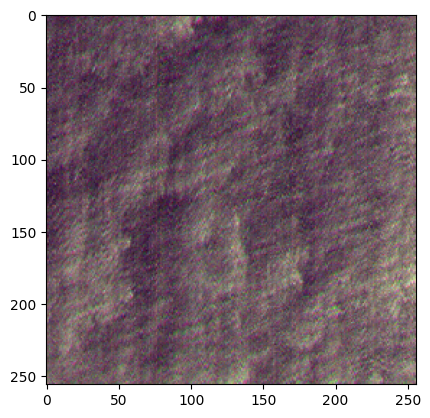

In [5]:
# %matplotlib inline
# import matplotlib.pyplot as plt
# image_test = pickle.load(open('/home/cristopher/Documents/PyRawS/modifications_cristopher/dataset_creation/dataset/images/event/NIR_SWIR/Barren_Island_10_G1_(384, 0, 640, 256)_NIR_SWIR.pkl','rb'))

# def normalize(band):
#     # Function that converts 16bits images into 8bits images
#     band_max, band_min = band.max(), band.min()
#     return (((band - band_min) / ((band_max - band_min))) * 255).astype(np.uint8)

# # image_test.max()
# plt.imshow(normalize(image_test))


In [3]:
#### This section of the code searches for those potential events that have voting 3, voting2 and intersection. Then, it creates folders inside comparison_plots for each case.


%matplotlib inline
import os
import pickle
import numpy as np
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt

import gc

from memory_profiler import profile

import shutil

# events_images_path = os.path.join(os.getcwd(),'dataset','images','potential_event','NIR_SWIR')

# events_masks_castro_traba = os.path.join(os.getcwd(),'dataset','masks','Castro-Traba',os.path.basename(os.path.dirname(events_images_path)))
# events_masks_massimetti = os.path.join(os.getcwd(),'dataset','masks','Massimetti',os.path.basename(os.path.dirname(events_images_path)))
# events_masks_murphy = os.path.join(os.getcwd(),'dataset','masks','Murphy',os.path.basename(os.path.dirname(events_images_path)))
# events_masks_schroeder = os.path.join(os.getcwd(),'dataset','masks','Schroeder',os.path.basename(os.path.dirname(events_images_path)))
# events_masks_kumar_roy = os.path.join(os.getcwd(),'dataset','masks','Kumar-Roy',os.path.basename(os.path.dirname(events_images_path)))

# images_path = [os.path.join(events_images_path,image_path) for image_path in os.listdir(events_images_path)]

masks_comparison_path = os.path.join(os.getcwd(),'dataset','masks','comparison','potential_events')
masks_comparison_plot_path = os.path.join(masks_comparison_path,'comparison_plot')
masks_intersection_path = os.path.join(masks_comparison_path,'intersection')
masks_voting_2_path = os.path.join(masks_comparison_path,'voting','voting_2')
masks_voting_3_path = os.path.join(masks_comparison_path,'voting','voting_3')

masks_comparison_plot_notevents_path = os.path.join(masks_comparison_plot_path,'notevents')
masks_comparison_plot_voting_2_path = os.path.join(masks_comparison_plot_path,'voting_2')
masks_comparison_plot_voting_3_path = os.path.join(masks_comparison_plot_path,'voting_3')
masks_comparison_plot_intersection_path = os.path.join(masks_comparison_plot_path,'intersection')



intersection_images = [re.match(r'(.+)_NIR_SWIR',image_name).group(1) for image_name in os.listdir(masks_intersection_path)]
voting_2_images = [re.match(r'(.+)_NIR_SWIR',image_name).group(1) for image_name in os.listdir(masks_voting_2_path)]
voting_3_images = [re.match(r'(.+)_NIR_SWIR',image_name).group(1) for image_name in os.listdir(masks_voting_3_path)]

# directories_to_create = [masks_comparison_plot_notevents_path,masks_comparison_plot_voting_2_path,masks_comparison_plot_voting_3_path,masks_comparison_plot_intersection_path]

# for directory in directories_to_create:
#     os.makedirs(directory, exist_ok=True)

# # cont = 1

# # image_masks = []

for image_path in tqdm(os.listdir(masks_comparison_plot_path)):

    image_name = re.match(r'(.+)_NIR_SWIR',image_path).group(1)
    if image_name in intersection_images:
        shutil.copyfile(os.path.join(masks_comparison_plot_path,image_path),os.join.path(masks_comparison_plot_intersection_path,image_path))
        shutil.copyfile(os.path.join(masks_comparison_plot_path,image_path),os.join.path(masks_comparison_plot_voting_2_path,image_path))
        shutil.copyfile(os.path.join(masks_comparison_plot_path,image_path),os.join.path(masks_comparison_plot_voting_3_path,image_path))
    else:
        if image_name in voting_3_images:
            shutil.copyfile(os.path.join(masks_comparison_plot_path,image_path),os.join.path(masks_comparison_plot_voting_3_path,image_path))
            shutil.copyfile(os.path.join(masks_comparison_plot_path,image_path),os.join.path(masks_comparison_plot_voting_2_path,image_path))
        else:
            if image_name in voting_2_images:
                shutil.copyfile(os.path.join(masks_comparison_plot_path,image_path),os.join.path(masks_comparison_plot_voting_2_path,image_path))
            else:
                shutil.copyfile(os.path.join(masks_comparison_plot_path,image_path),os.join.path(masks_comparison_plot_notevents_path,image_path))

    os.remove(os.path.join(masks_comparison_plot_path,image_path)) # Delete the file from its original location

# #     gc.collect()

        # cont +=1
        # if cont>1:
        #     break


1801

In [2]:
%matplotlib inline

import os
import numpy as np
import matplotlib.pyplot as plt
from patchify import patchify

import pickle

def normalize_to_0_to_1(img):
    """Normalizes the passed image to 0 to 1

    Args:
        img (np.array): image to normalize

    Returns:
        np.array: normalized image
    """
    # img = img + np.minimum(0, np.min(img))  # move min to 0
    # img = img / np.max(img)  # scale to 0 to 1
    img = img / 4095  # scale to 0 to 1
    return img


def normalize(band):
    # Function that converts 16bits images into 8bits images
    band_max, band_min = band.max(), band.min()
    return (((band - band_min) / ((band_max - band_min))) * 255).astype(np.uint8)


from coregistration_superglue_multiband import SuperGlue_registration

bands_list = [ "B02", "B08", "B03", "B04", "B05","B11", "B06", "B07","B8A","B12"]
# bands_list = [ "B02", "B03", "B04","B12", "B11", "B8A"]


data_path = '/home/cristopher/Documents/PyRawS/data/raw'


scene_groups_paths = [
            os.path.join(data_path,d) for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))
        ]


# desired_scene_name = 'Karangetang_01'
# desired_scene_name = 'Spain_1'
desired_scene_name = 'Etna_02'

# desired_granule_idx = 0
desired_granule_idx = 0


scene_name_condition = False
# Process creating loop
for i,scene_group_path in enumerate(scene_groups_paths):
    
        scenes_paths = [
                os.path.join(scene_group_path,scene_name) for scene_name in os.listdir(scene_group_path) if os.path.isdir(os.path.join(scene_group_path, scene_name))
            ]
        
        for scene_path in scenes_paths:
            granules_paths = [
                os.path.join(scene_path,granule_name) for granule_name in os.listdir(scene_path) if os.path.isdir(os.path.join(scene_path, granule_name))
            ]
            scene_name = os.path.basename(scene_path)

            if scene_name == desired_scene_name:
                print(scene_name)
                for granule_idx in range(len(granules_paths)):

                    if granule_idx == desired_granule_idx:
                        raw_coreg_granule,coarse_status = SuperGlue_registration(bands_list=bands_list,event_path=scene_path,granule_idx=granule_idx)

                        raw_coordinates = raw_coreg_granule.get_granule_coordinates()
                        print(raw_coordinates)
                        raw_coreg_granule = raw_coreg_granule.as_tensor().numpy()

                        # NIR_SWIR_image = normalize_to_0_to_1(np.dstack((raw_coreg_granule[:,:,9],raw_coreg_granule[:,:,5],raw_coreg_granule[:,:,8])))

                        # NIR_SWIR_patches = patchify(NIR_SWIR_image, (256,256,3), step=192)
                        # print(NIR_SWIR_patches.shape)

                        # plt.figure()
                        # plt.imshow(NIR_SWIR_image)
                        # plt.show()



                        # # for i in range(NIR_SWIR_patches.shape[0]):
                        # #     for j in range(NIR_SWIR_patches.shape[1]):
                        
                        # i = 4
                        # j = 2

                        # patch_name = f'{scene_name}_G{granule_idx}_({j*192}, {i*192}, {256+j*192}, {256+i*192})'
                        # print(patch_name)
                        # NIR_SWIR_name = f'{patch_name}_NIR_SWIR'

                        # NIR_SWIR_patch = NIR_SWIR_patches[i,j,:,:,:].reshape(256,256,3)
                        
                        # print(f'{patch_name}, MAX: {NIR_SWIR_patch.max()} MIN: {NIR_SWIR_patch.min()}')
                        # plt.figure()
                        # plt.imshow(NIR_SWIR_patch)
                        # plt.show()

                        # # with open(os.path.join(os.getcwd(),NIR_SWIR_name+'.pkl'),'wb') as f:
                        # #     pickle.dump(NIR_SWIR_patch, f)

                        # # with open(os.path.join(os.getcwd(),NIR_SWIR_name+'.pkl'),'rb') as f:
                        # #     saved_patch = pickle.load(f)
                        # #     print(f'Saved patch: MAX {saved_patch.max()} MIN {saved_patch.min()}')


                        scene_name_condition = True
                        break
                if scene_name_condition:
                    break
        if scene_name_condition:
            break

Etna_02
[[38.0685823849948, 15.0057431512065], [37.7023764187711, 14.899681395882], [37.658764307956, 15.1975296610552], [38.0232835517031, 15.3054022448107]]


In [31]:
import rasterio
from rasterio.control import GroundControlPoint
from osgeo import gdal, gdalconst
raw_coordinates
pixel_list = [[0,0],[raw_coreg_granule.shape[1],0],[raw_coreg_granule.shape[1],raw_coreg_granule.shape[0]],[0,raw_coreg_granule.shape[0]]]
pixel_list[1]
gcps_list = []
for i in range(4):
        # gcps_list.append(GroundControlPoint(col=pixel_list[i][1], row=pixel_list[i][0], x=raw_coordinates[i][1], y=raw_coordinates[i][0]))
        # structure GCP (lon, lat, alt, pixel (col), line (row))
        gcps_list.append(gdal.GCP(raw_coordinates[i][1],raw_coordinates[i][0],0,pixel_list[i][1],pixel_list[i][0]))
gcps_list

[<osgeo.gdal.GCP; proxy of <Swig Object of type 'GDAL_GCP *' at 0x7fd921ee14d0> >,
 <osgeo.gdal.GCP; proxy of <Swig Object of type 'GDAL_GCP *' at 0x7fd921ee2fd0> >,
 <osgeo.gdal.GCP; proxy of <Swig Object of type 'GDAL_GCP *' at 0x7fd921ee3330> >,
 <osgeo.gdal.GCP; proxy of <Swig Object of type 'GDAL_GCP *' at 0x7fd921ee3420> >]

In [30]:
# output_path = 'testing_2.tif'

# new_granule = np.transpose(raw_coreg_granule,(2,0,1))

# with rasterio.open(
#                         output_path,
#                         "w",
#                         driver="GTiff",
#                         height=new_granule.shape[1],
#                         width=new_granule.shape[2],
#                         count=10,
#                         dtype=new_granule.dtype,
#                         transform=rasterio.transform.from_gcps(gcps_list),
#                         nodata=0,
#                     ) as dst:
#                         dst.write(new_granule)  # Write the data to the dataset (band 1)

# print(rasterio.open(output_path).shape)


(1152, 1296)


In [59]:
output_path = 'testing.tif'
test_raster = rasterio.open(output_path)


transform = test_raster.transform


input_file = output_path
output_file = input_file[:-4] + "_georeferenced.tif"
temp_file = "/tmp/" + os.path.basename(input_file)

gdal.Translate(temp_file, input_file, format="GTiff", GCPs=gcps_list)

# Warp the translated file using gdalwarp
gdal.Warp(
    output_file,
    temp_file,
    format="GTiff",
    resampleAlg=gdalconst.GRA_Bilinear,
    # resampleAlg=gdalconst.GRA_NearestNeighbour,
    # resampleAlg=gdalconst.GRA_CubicSpline,
    dstSRS="EPSG:4326",
    options=["-co", "COMPRESS=None"],
)

# Clean up the temporary file
os.remove(temp_file)

In [62]:
new_raster = rasterio.open(output_file)
new_raster_transform = new_raster.transform

idx_corner =3
x_coords_reprojected, y_coords_reprojected = rasterio.transform.rowcol(new_raster_transform, raw_coordinates[idx_corner][1], raw_coordinates[idx_corner][0])
print(raw_coordinates[idx_corner])
print(x_coords_reprojected,y_coords_reprojected)

print(new_raster.shape)

print(new_raster.transform * (0,0))
print(new_raster.transform * (0,new_raster.shape[0]))
print(new_raster.transform * (new_raster.shape[1],new_raster.shape[0]))
print(new_raster.transform * (new_raster.shape[1],0))



[38.0232835517031, 15.3054022448107]
174 1534
(1458, 1678)
(14.911113929834249, 38.06816070437565)
(14.911113929834249, 37.693495020995385)
(15.342313529773953, 37.693495020995385)
(15.342313529773953, 38.06816070437565)


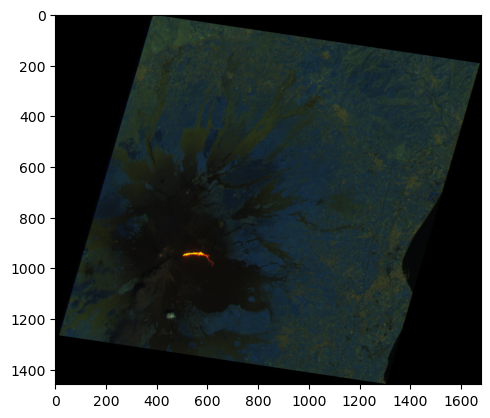

In [41]:
image_raster = new_raster.read()
%matplotlib inline
plt.imshow(normalize(np.dstack((image_raster[9,:,:],image_raster[5,:,:],image_raster[8,:,:]))))
plt.show()

In [10]:
from rasterio.warp import reproject, Resampling, calculate_default_transform

new_granule = np.transpose(raw_coreg_granule,(2,0,1))

crs = "EPSG:4326"

transform, width, height = calculate_default_transform(
    src_crs=crs,
    dst_crs=crs,
    width=new_granule.shape[2], 
    height=new_granule.shape[1],
    gcps=gcps_list)


print(transform*(0,0))
print(transform*(1296,0))
print(transform*(1296,1192))
print(transform*(0,1192))

# output_image_path = 'tesitng_2.tif'

# with rasterio.open(output_image_path, "w", 
#                    driver="GTiff",
#                    height=new_granule.shape[1],
#                    width=new_granule.shape[2],
#                    count=10,
#                    dtype=new_granule.dtype,

#                    nodata=0,) as dst:
#                    reproject(
#                        source=rasterio.band(src_image, 1),  # Source band (input image)
#                        destination=rasterio.band(
#                            dst, 1
#                        ),  # Destination band (output image)
#                        src_transform=image_transform,
#                        dst_transform=transform,
#                        resampling=Resampling.bilinear,  # Resampling method (adjust as needed)
#                    )

(14.911113929834249, 38.06816070437565)
(15.244150092838932, 38.06816070437565)
(15.244150092838932, 37.7618496655627)
(14.911113929834249, 37.7618496655627)


In [28]:
raster_transform = rasterio.transform.from_gcps(gcps_list)
top_left = (raster_transform * pixel_list[0])
bottom_left = (raster_transform * pixel_list[1])
bottom_right = (raster_transform * pixel_list[2])
top_right = (raster_transform * pixel_list[3])


print(top_left,bottom_left,bottom_right,top_right)

(15.006195858314252, 38.06816070437565) (15.342293747626538, 38.01814829831557) (15.247211819146537, 37.69338153832855) (14.91111392983425, 37.74339394438863)


In [1]:
test_raster = rasterio.open(output_path)

test_raster.bounds

# top_lat = (test_raster.transform * (0, 0))[1]
# bottom_lat = (test_raster.transform * (0,raw_coreg_granule.shape[0]))[1]
# east_lon = (test_raster.transform * (raw_coreg_granule.shape[1],0))[0]
# west_lon = (test_raster.transform * (0, 0))[0]


# print(top_lat,bottom_lat,east_lon,west_lon)

NameError: name 'rasterio' is not defined

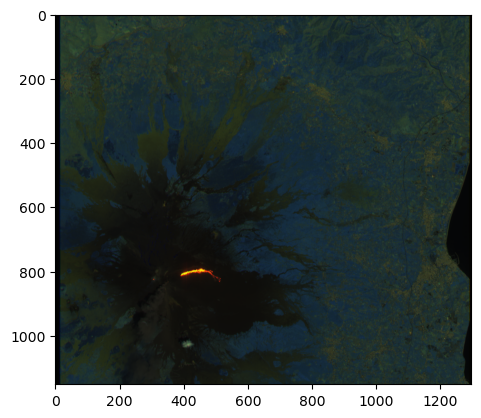

In [16]:
%matplotlib inline
plt.imshow(normalize(NIR_SWIR_image))
plt.show()

from PIL import Image
Image.fromarray(normalize(NIR_SWIR_patch)).save(os.path.join(os.getcwd(),'null_patches.png'))


0.22173382 0.0 0.2017094 0.0 0.22930403 0.011721612


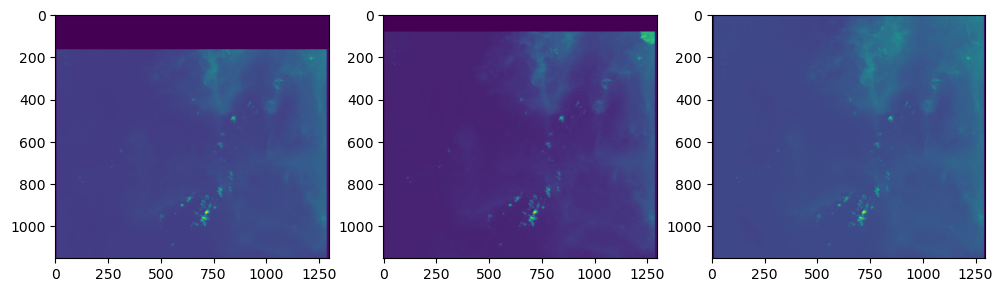

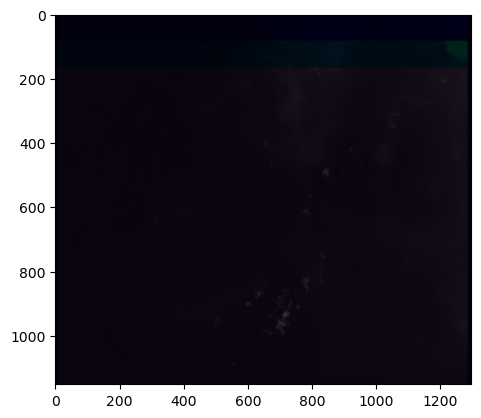

In [11]:
a = NIR_SWIR_image.copy()

a0 = a[:,:,0]
a1 = a[:,:,1]
a2 = a[:,:,2]
plt.figure(figsize=(12,12))
plt.subplot(1,3,1)
plt.imshow(a0)
plt.subplot(1,3,2)
plt.imshow(a1)
plt.subplot(1,3,3)
plt.imshow(a2)

plt.figure()
plt.imshow(NIR_SWIR_image)
print(a0.max(),a0.min(),a1.max(),a1.min(),a2.max(),a2.min())

